<a href="https://colab.research.google.com/github/ingoscargiraldor/ingoscargiraldor/blob/main/Series_Tiempo_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Entrenamiento de modelo con series de Tiempo Parte 3

En este cuaderno veremos la implementación del modelo

ARMA

Un modelo ARMA combina los componentes AR y MA para modelar una serie temporal. En un modelo ARMA(p, q), se utilizan ambos componentes para capturar las relaciones entre los valores pasados, los términos de error pasados y el valor actual.

Matemáticamente, un modelo ARMA(p, q) se expresa como:

Y(t) = c + φ₁ * Y(t-1) + φ₂ * Y(t-2) + ... + φₚ * Y(t-p) + ε(t) + θ₁ * ε(t-1) + θ₂ * ε(t-2) + ... + θᵠ * ε(t-q)

donde Y(t) es el valor en el tiempo "t", φ₁, φ₂, ..., φₚ son los coeficientes de autorregresión, θ₁, θ₂, ..., θᵠ son los coeficientes de media móvil, "c" es una constante, y ε(t) es el término de error aleatorio.

En resumen, un modelo ARMA se utiliza para modelar y predecir datos de series temporales considerando tanto las relaciones autorregresivas como las de media móvil. La elección de los valores de "p" y "q" se basa en el análisis de datos y en técnicas de selección de modelos. Estos modelos son ampliamente utilizados en finanzas, economía, climatología y otros campos donde se necesita modelar y predecir datos temporales.

In [42]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Se importan los datos, que es un dataset en un archivo de Excel

In [43]:
archivo_excel = "data/DatosCQ.xlsx"
df = pd.read_excel(archivo_excel)

## Se revisan los tipos de datos disponibles del dataset.

In [44]:
df.dtypes

Factura                                                   int64
Fecha de contabilización                         datetime64[ns]
nombre_cliente                                           object
Nombre de empleado del departamento de ventas            object
Descripción del artículo                                 object
Lote                                                     object
Ciudad                                                   object
Cantidad                                                  int64
Precio Unitario                                           int64
Impuesto total                                          float64
Número de referencia del SN                              object
Código de proyecto                                      float64
Número de artículo                                        int64
Atributo de lote 2                                       object
Fecha de vencimiento                             datetime64[ns]
Fecha de fabricación                    

## Se crea un nuevo dataset con los datos que se van a a utilizar para la serie de tiempo ARMA

In [48]:
# Selecciona las columnas "Fecha de contabilización" y "calculo_total_lineas"
nuevo_df = df.loc[:, ["Fecha de contabilización", "calculo_total_lineas"]]

## Nueva estructura del dataset nuevo.

In [49]:
nuevo_df.shape

(9158, 2)

## Visualización de los datos segmentados y necesarios para el modelo ARMA

In [50]:
nuevo_df.head(6)

,Fecha de contabilización,calculo_total_lineas
0,2020-09-25,18750000
1,2020-09-25,62500000
2,2020-06-12,48000000
3,2020-06-18,44000000
4,2020-07-01,16500000
5,2020-07-01,11500000


## Para cumplir con estacionareidad se agrupan los datos de total_lineas por Mes, y cada numero de Mes tendra el valor total de la suma de la columba total_lineas correspondiente para ese Mes y ese año.

In [51]:
import pandas as pd

# Supongamos que tienes un DataFrame llamado 'nuevo_df' con las columnas 'Fecha de contabilización' y 'calculo_total_lineas'

# Convierte la columna 'Fecha de contabilización' al formato de fecha
nuevo_df['Fecha de contabilización'] = pd.to_datetime(nuevo_df['Fecha de contabilización'])

# Extrae el año y el mes de la fecha
nuevo_df['Año'] = nuevo_df['Fecha de contabilización'].dt.year
nuevo_df['Mes'] = nuevo_df['Fecha de contabilización'].dt.month

# Agrupa los datos por año y mes y suma los valores de 'calculo_total_lineas'
resultados = nuevo_df.groupby(['Año', 'Mes'], as_index=False)['calculo_total_lineas'].sum()

# Para tener una representación más legible, puedes crear una nueva columna que combine el año y el mes
resultados['Año-Mes'] = resultados.apply(lambda row: f"{int(row['Año'])}-{int(row['Mes'])}", axis=1)


## Graficamos los valores luego de la agrupación por mes

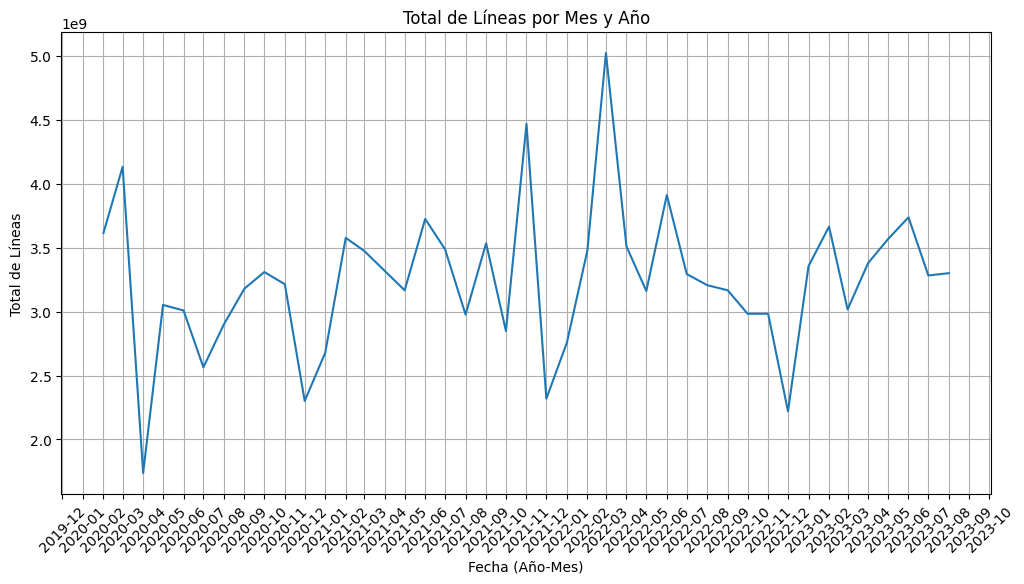

In [52]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Supongamos que tienes un DataFrame llamado 'resultados' con las columnas 'Año-Mes' y 'calculo_total_lineas'

# Convierte la columna 'Año-Mes' al formato de fecha para ordenar cronológicamente
resultados['Año-Mes'] = pd.to_datetime(resultados['Año-Mes'])

# Ordena el DataFrame por la columna 'Año-Mes' para asegurarte de que los datos estén organizados por antigüedad
resultados = resultados.sort_values(by='Año-Mes')

# Grafica los datos en orden cronológico con etiquetas mensuales en el eje x
plt.figure(figsize=(12, 6))
plt.plot(resultados['Año-Mes'], resultados['calculo_total_lineas'], label='Total de Líneas')
plt.title('Total de Líneas por Mes y Año')
plt.xlabel('Fecha (Año-Mes)')
plt.ylabel('Total de Líneas')
plt.xticks(rotation=45)  # Rotar las etiquetas del eje x en 45 grados para una mejor legibilidad
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Formato de etiquetas con año y mes
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Etiquetas para cada mes
plt.grid(True)
plt.show()


## Visualización del nuevo dataset donde utilizarremos calculo_total_lineas y Año-Semana.

In [53]:
resultados.head(6)

,Año,Mes,calculo_total_lineas,Año-Mes
0,2020,2,3613097397,2020-02-01
1,2020,3,4131160800,2020-03-01
2,2020,4,1738295600,2020-04-01
3,2020,5,3051354025,2020-05-01
4,2020,6,3008474469,2020-06-01
5,2020,7,2564146104,2020-07-01


## Separación de datos distribuidos por 80% entrenamiento 20% prueba, organizados de manera cronologica debido a las mejores practicas de un entrenamiento de un modelo de series de tiempo.

In [54]:
# Ordena el DataFrame por la columna 'Año-Semana' para asegurarte de que los datos estén organizados por antigüedad
resultados = resultados.sort_values(by='Año-Mes')

# Define la proporción para la división entre entrenamiento y prueba
train_proportion = 0.8

# Calcula el índice para dividir los datos
split_index = int(len(resultados) * train_proportion)

# Divide el conjunto de datos en entrenamiento y prueba en función del índice calculado
train = resultados[:split_index]
test = resultados[split_index:]

## Validación de estacionareidad de los dataset particionados, de entrenamiento y el dataset de validación, como se evidencia en la grafica los valores estan cronologicamente ordenados.

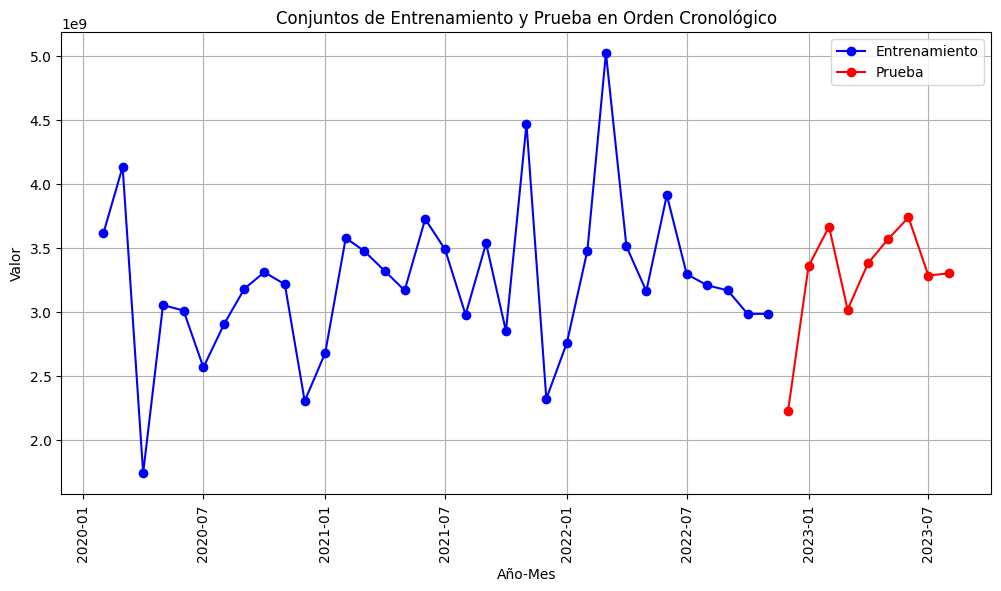

In [55]:
import matplotlib.pyplot as plt

# Ordena los conjuntos de datos de entrenamiento y prueba por 'Año-Mes'
train = train.sort_values(by='Año-Mes')
test = test.sort_values(by='Año-Mes')

# Grafica los datos de entrenamiento en azul y los datos de prueba en rojo
plt.figure(figsize=(12, 6))
plt.plot(train['Año-Mes'], train['calculo_total_lineas'], label='Entrenamiento', marker='o', color='blue')
plt.plot(test['Año-Mes'], test['calculo_total_lineas'], label='Prueba', marker='o', color='red')
plt.xlabel('Año-Mes')
plt.ylabel('Valor')
plt.title('Conjuntos de Entrenamiento y Prueba en Orden Cronológico')
plt.legend()

# Rotar los labels del eje x en 90 grados
plt.xticks(rotation=90)

plt.grid(True)
plt.show()


In [56]:
train.head(10)

,Año,Mes,calculo_total_lineas,Año-Mes
0,2020,2,3613097397,2020-02-01
1,2020,3,4131160800,2020-03-01
2,2020,4,1738295600,2020-04-01
3,2020,5,3051354025,2020-05-01
4,2020,6,3008474469,2020-06-01
5,2020,7,2564146104,2020-07-01
6,2020,8,2900228584,2020-08-01
7,2020,9,3179421000,2020-09-01
8,2020,10,3308512874,2020-10-01
9,2020,11,3213453775,2020-11-01


In [57]:
test.head(10)

,Año,Mes,calculo_total_lineas,Año-Mes
34,2022,12,2220360500,2022-12-01
35,2023,1,3354667500,2023-01-01
36,2023,2,3663962600,2023-02-01
37,2023,3,3016006200,2023-03-01
38,2023,4,3378752500,2023-04-01
39,2023,5,3565805500,2023-05-01
40,2023,6,3736117955,2023-06-01
41,2023,7,3281917000,2023-07-01
42,2023,8,3299826490,2023-08-01


## Vamos arelaizar algun analisis univariado de los dos datasets luego de la separación de datos para revisar que las estadisticas tiendan a ser lo mismo.

In [58]:
train["calculo_total_lineas"].nunique()

34

In [59]:
train["calculo_total_lineas"].value_counts(dropna=False, normalize=False) # You can set normalize to False for calculating the absolute frecuency

3613097397    1
5020434350    1
3533424500    1
2848087555    1
4466335450    1
2319033695    1
2756487200    1
3477733300    1
3509402200    1
4131160800    1
3160079165    1
3910485842    1
3293087800    1
3205920725    1
3165840100    1
2982425275    1
2976174880    1
3486473150    1
3723566900    1
3166130094    1
3316913700    1
3473547349    1
3575700929    1
2677328500    1
2301421508    1
3213453775    1
3308512874    1
3179421000    1
2900228584    1
2564146104    1
3008474469    1
3051354025    1
1738295600    1
2982681000    1
Name: calculo_total_lineas, dtype: int64

In [60]:
train["calculo_total_lineas"].describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95])

count    3.400000e+01
mean     3.236378e+09
std      6.110454e+08
min      1.738296e+09
5%       2.312869e+09
25%      2.977737e+09
50%      3.192671e+09
75%      3.503670e+09
95%      4.248472e+09
max      5.020434e+09
Name: calculo_total_lineas, dtype: float64

In [61]:
# Let's make some calculations for determining an outlier threshold
q1 = train["calculo_total_lineas"].quantile(0.25)
q3 = train["calculo_total_lineas"].quantile(0.75)
iqr = q3 - q1

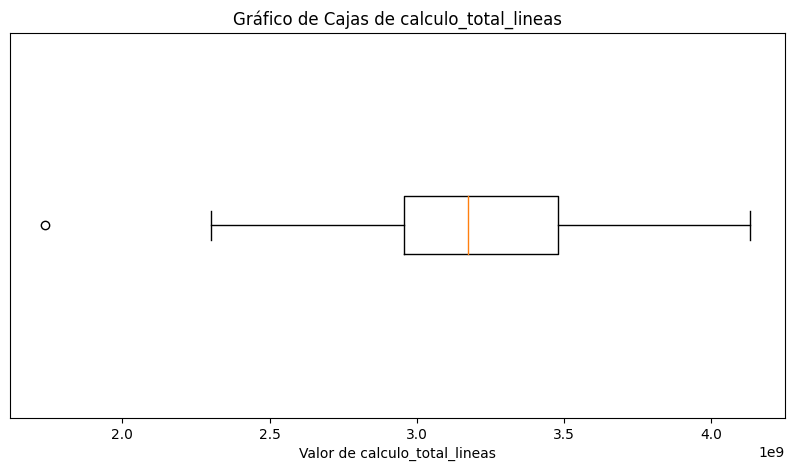

In [62]:
# Box plot for CANTIDAD
# Filter the values of "CANTIDAD" that meet your condition
data_filtered = train.loc[train["calculo_total_lineas"] <= (q3 + 1.5 * iqr)]["calculo_total_lineas"]

# Creates a box plot with the filtered values
plt.figure(figsize=(10, 5))
plt.boxplot(data_filtered, vert=False)  # vert=False for a horizontal graphic

# Sets the title and labels of the axes
plt.title("Gráfico de Cajas de calculo_total_lineas")
plt.xlabel("Valor de calculo_total_lineas")
plt.yticks([])  # Remove y-axis labels (if you don't want to display them)

plt.show()

## Ahora se realizara un analisis univariado del conjunto de datos para pruebas

In [63]:
test["calculo_total_lineas"].nunique()

9

In [64]:
test["calculo_total_lineas"].value_counts(dropna=False, normalize=False) # You can set normalize to False for calculating the absolute frecuency

2220360500    1
3354667500    1
3663962600    1
3016006200    1
3378752500    1
3565805500    1
3736117955    1
3281917000    1
3299826490    1
Name: calculo_total_lineas, dtype: int64

In [65]:
test["calculo_total_lineas"].describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95])

count    9.000000e+00
mean     3.279713e+09
std      4.535151e+08
min      2.220360e+09
5%       2.538619e+09
25%      3.281917e+09
50%      3.354668e+09
75%      3.565806e+09
95%      3.707256e+09
max      3.736118e+09
Name: calculo_total_lineas, dtype: float64

In [66]:
# Let's make some calculations for determining an outlier threshold
q1 = test["calculo_total_lineas"].quantile(0.25)
q3 = test["calculo_total_lineas"].quantile(0.75)
iqr = q3 - q1

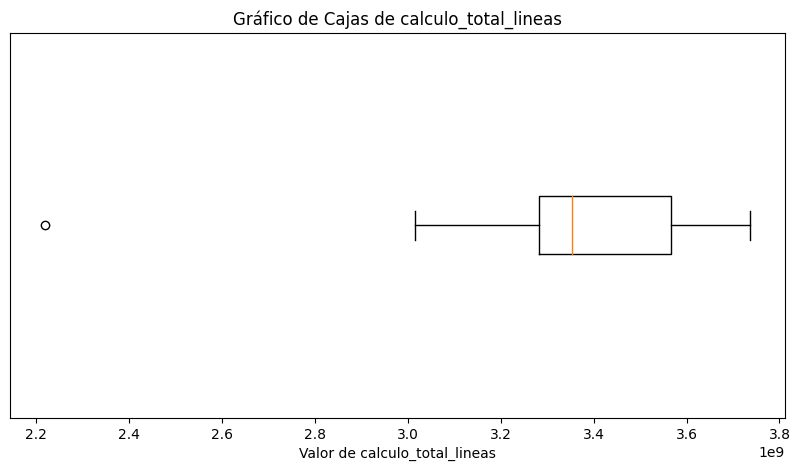

In [67]:
# Box plot for CANTIDAD
# Filter the values of "CANTIDAD" that meet your condition
data_filtered = test.loc[test["calculo_total_lineas"] <= (q3 + 1.5 * iqr)]["calculo_total_lineas"]

# Creates a box plot with the filtered values
plt.figure(figsize=(10, 5))
plt.boxplot(data_filtered, vert=False)  # vert=False for a horizontal graphic

# Sets the title and labels of the axes
plt.title("Gráfico de Cajas de calculo_total_lineas")
plt.xlabel("Valor de calculo_total_lineas")
plt.yticks([])  # Remove y-axis labels (if you don't want to display them)

plt.show()

## La media y la variación estandar estan cercanas sin embargo tienen una diferencia considerable entre los 2 conjutnos definidos para el entrenamiento y las pruebas

## A continuación se mostrara el modelo ARMA y los resultados bajo un aprueba de 5 distintos valores para los parametros p y q, (50, 50), (15, 15), (5, 5), (3, 2), (1, 1), sobre la grafica podemos ver el ajuste para cada valor, adicional a los datos de MSE, RMSE e IAC.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


({50}, {50})
MSE: 7.08509497682497e+17
RMSE: 841730062.242342
AIC: 1648.3435570969536


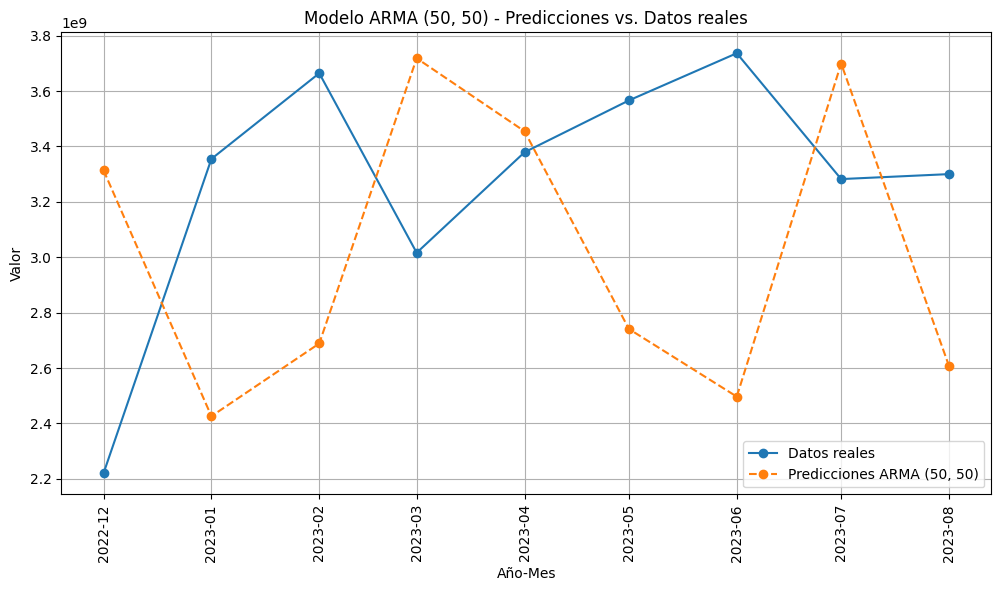

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


({15}, {15})
MSE: 7.260020963465114e+17
RMSE: 852057566.3337022
AIC: 1518.9572575231264


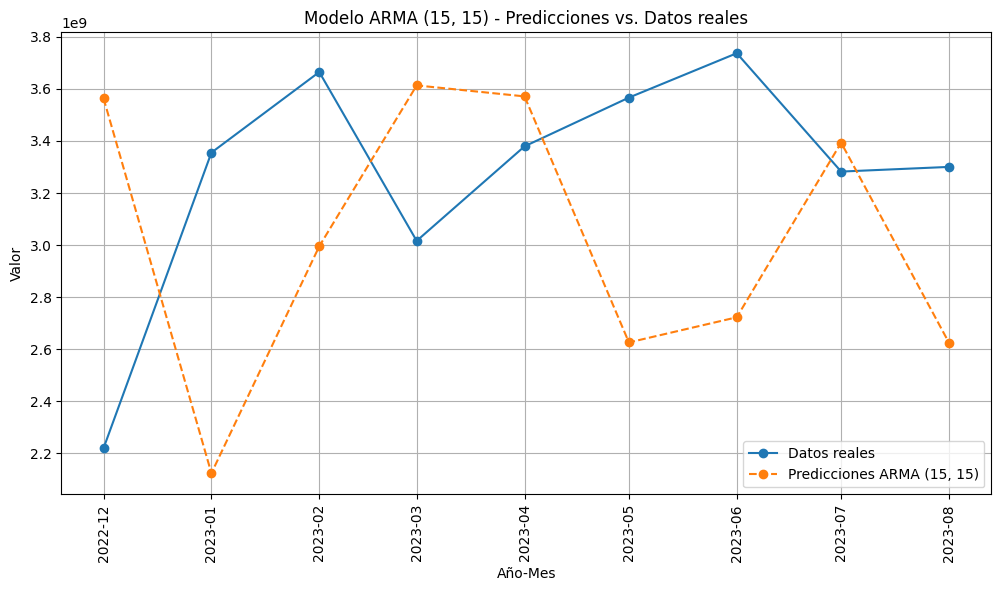

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


({5}, {5})
MSE: 2.857374765492036e+17
RMSE: 534544176.4243659
AIC: 1489.1530182008073


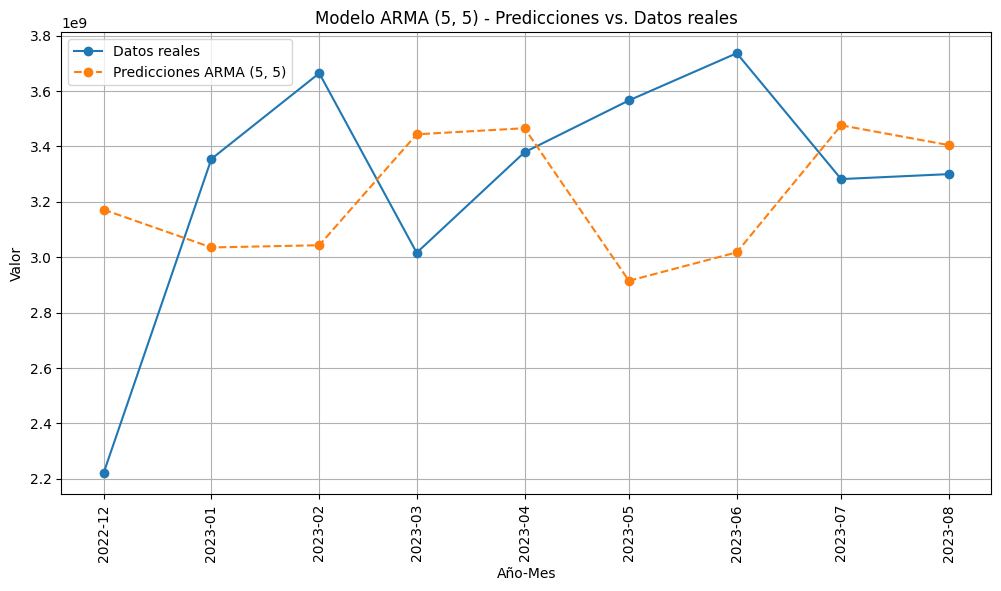

({3}, {2})
MSE: 3.207793570268358e+17
RMSE: 566373866.8290017
AIC: 1480.5363690578044


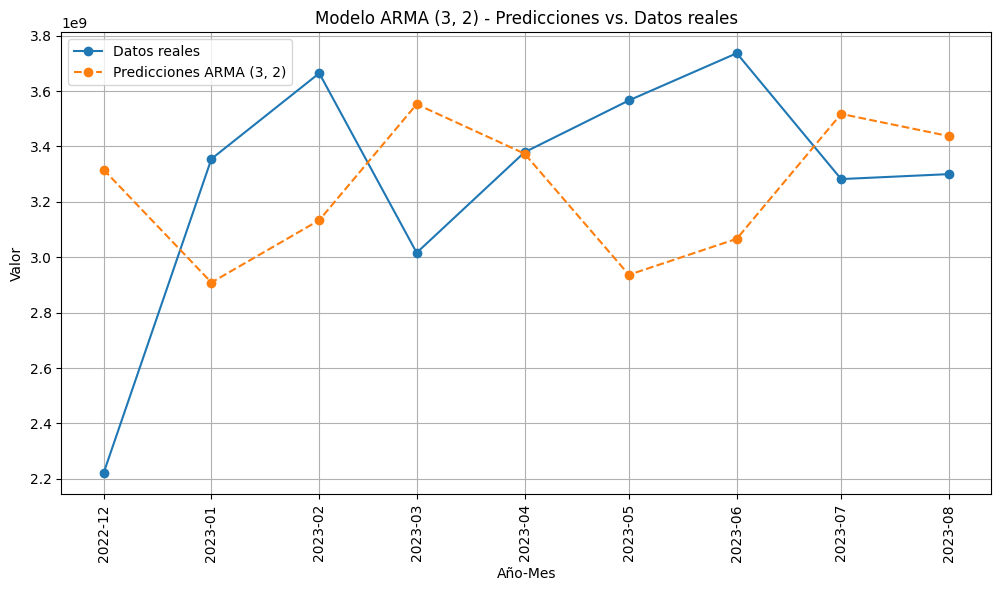

({1}, {1})
MSE: 1.8878677419615296e+17
RMSE: 434496000.2073126
AIC: 1479.6073678390053


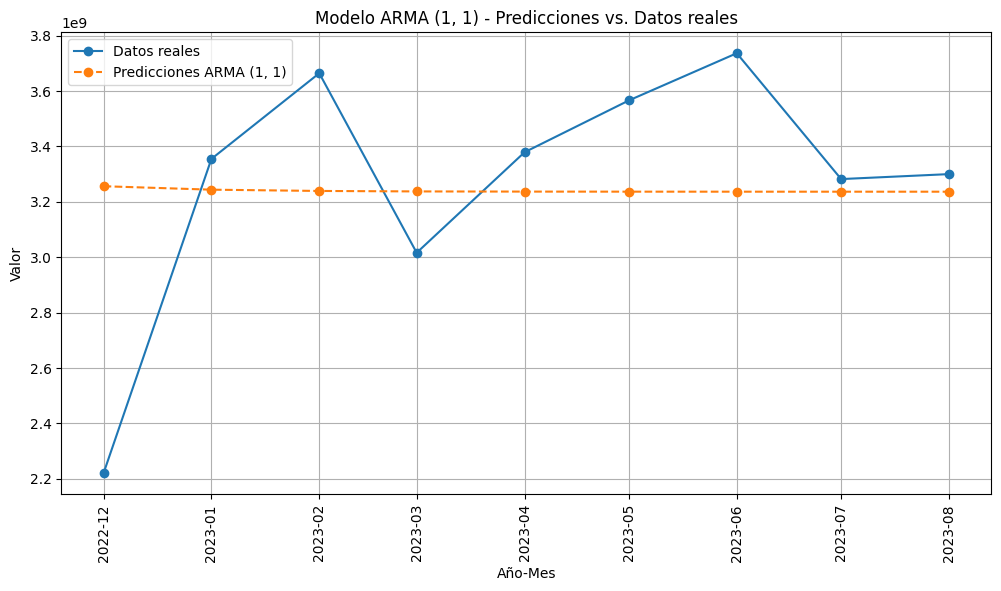

In [68]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Supongamos que ya tienes 'train' y 'test' como conjuntos de datos de entrenamiento y prueba

# Asegúrate de que los datos estén ordenados cronológicamente
train = train.sort_values(by='Año-Mes')
test = test.sort_values(by='Año-Mes')

# Define una lista de combinaciones de parámetros para ARMA (p, q)
param_combinations_arma = [(50, 50), (15, 15), (5, 5), (3, 2), (1, 1)]  # Puedes ajustar estos valores según tus necesidades

# Itera a través de las combinaciones de parámetros y genera gráficos independientes
for p, q in param_combinations_arma:
    # Ajusta un modelo ARIMA con d=0 para simular un modelo ARMA
    model = sm.tsa.ARIMA(train['calculo_total_lineas'], order=(p, 0, q))
    model_fit = model.fit()

    # Realiza predicciones en el conjunto de prueba
    predictions = model_fit.predict(start=len(train), end=len(train) + len(test) - 1)

    # Calcula el MSE y RMSE
    mse = mean_squared_error(test['calculo_total_lineas'], predictions)
    rmse = np.sqrt(mse)

    # Calcula el AIC
    aic = model_fit.aic

    # Imprime las
    print(({p}, {q}))
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'AIC: {aic}')

    # Grafica las predicciones y los datos reales en orden cronológico
    plt.figure(figsize=(12, 6))
    plt.plot(test['Año-Mes'], test['calculo_total_lineas'], label='Datos reales', marker='o')
    plt.plot(test['Año-Mes'], predictions, label=f'Predicciones ARMA ({p}, {q})', linestyle='--', marker='o')
    plt.legend()
    plt.title(f'Modelo ARMA ({p}, {q}) - Predicciones vs. Datos reales')
    plt.xlabel('Año-Mes')
    plt.ylabel('Valor')

    # Rotar los labels del eje x en 90 grados
    plt.xticks(rotation=90)

    plt.grid(True)
    plt.show()



* Selección del Modelo:
    El modelo ARMA con (p=1, q=1) es el que mejor se ajusta a los datos y produce las predicciones más precisas en comparación con los otros modelos evaluados. Tiene los valores más bajos de MSE, RMSE y AIC, lo que sugiere un ajuste sólido y predicciones precisas.

* Importancia de la Selección de Parámetros:
    La elección de los valores de p y q en un modelo ARMA es crucial. Los modelos con valores altos de p y q (como p=50, q=50) pueden resultar en peores predicciones y un ajuste deficiente. Es importante buscar un equilibrio entre la complejidad del modelo y su capacidad para capturar la dinámica de los datos.

* Comparación de Modelos:
    La comparación de diferentes modelos ARMA es esencial. Las métricas como MSE, RMSE y AIC son herramientas útiles para evaluar y seleccionar el mejor modelo en función de tus objetivos y necesidades específicos.

* Precisión en las Predicciones:
    Los valores bajos de MSE y RMSE indican que el modelo ARMA con (p=1, q=1) tiene predicciones más precisas y está más cerca de los valores reales en promedio.

* AIC y Complejidad del Modelo:
    El AIC refleja el equilibrio entre la calidad del ajuste y la complejidad del modelo. Un valor más bajo de AIC sugiere un mejor equilibrio y preferencia por un modelo.

En resumen, la elección de un modelo ARMA adecuado es esencial para el análisis de series temporales. El modelo con (p=1, q=1) es el preferido en función de las métricas proporcionadas, pero es importante considerar el contexto, los objetivos y la interpretación de los resultados al seleccionar un modelo para aplicaciones prácticas. por ello el modelo que mas se ajusta a la temporalidad de los datos es el que mantiene los valores de p y q mas altos, aunque estadisticamente estos modelos tienen un error mas grande, sin embargo, revisando el negocio es el mas ajustable, p =3 y q = 2.

({3}, {2})
MSE: 3.207793570268358e+17
RMSE: 566373866.8290017
AIC: 1480.5363690578044


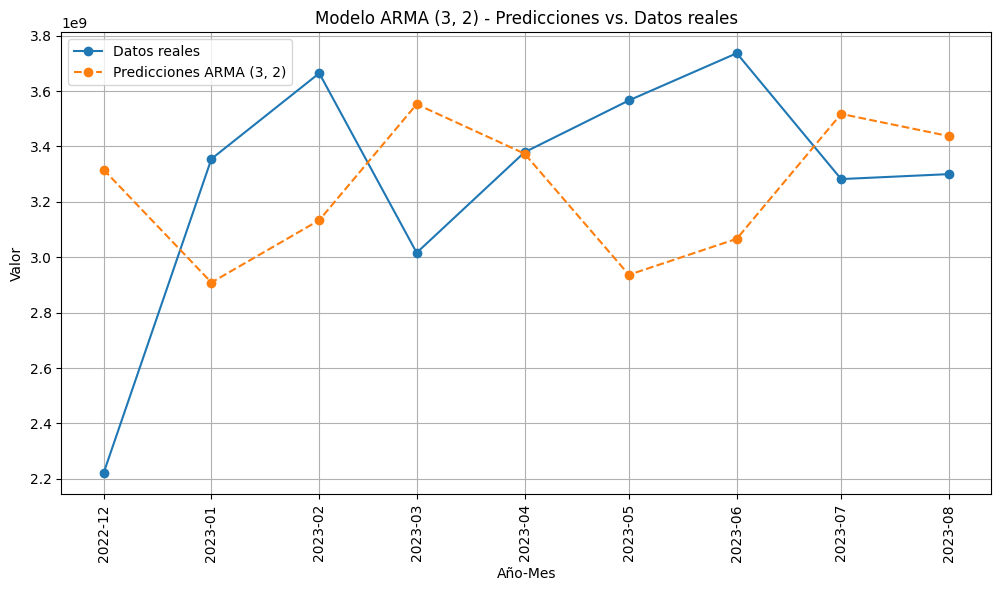

In [70]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Supongamos que ya tienes 'train' y 'test' como conjuntos de datos de entrenamiento y prueba

# Asegúrate de que los datos estén ordenados cronológicamente
train = train.sort_values(by='Año-Mes')
test = test.sort_values(by='Año-Mes')

# Define una lista de combinaciones de parámetros para ARMA (p, q)
param_combinations_arma = [(3, 2)]  # Puedes ajustar estos valores según tus necesidades

# Itera a través de las combinaciones de parámetros y genera gráficos independientes
for p, q in param_combinations_arma:
    # Ajusta un modelo ARIMA con d=0 para simular un modelo ARMA
    model = sm.tsa.ARIMA(train['calculo_total_lineas'], order=(p, 0, q))
    model_fit = model.fit()

    # Realiza predicciones en el conjunto de prueba
    predictions = model_fit.predict(start=len(train), end=len(train) + len(test) - 1)

    # Calcula el MSE y RMSE
    mse = mean_squared_error(test['calculo_total_lineas'], predictions)
    rmse = np.sqrt(mse)

    # Calcula el AIC
    aic = model_fit.aic

    # Imprime las
    print(({p}, {q}))
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'AIC: {aic}')

    # Grafica las predicciones y los datos reales en orden cronológico
    plt.figure(figsize=(12, 6))
    plt.plot(test['Año-Mes'], test['calculo_total_lineas'], label='Datos reales', marker='o')
    plt.plot(test['Año-Mes'], predictions, label=f'Predicciones ARMA ({p}, {q})', linestyle='--', marker='o')
    plt.legend()
    plt.title(f'Modelo ARMA ({p}, {q}) - Predicciones vs. Datos reales')
    plt.xlabel('Año-Mes')
    plt.ylabel('Valor')

    # Rotar los labels del eje x en 90 grados
    plt.xticks(rotation=90)

    plt.grid(True)
    plt.show()

## Validación de supuesto con el mejor modelo ARMA p=3 y q=2

In [71]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# Realiza la prueba de Dickey-Fuller aumentada (ADF) en los residuos del modelo ARMA
result = adfuller(model_fit.resid)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])


ADF Statistic: -5.506941457770968
p-value: 2.0119617322376923e-06
Critical Values: {'1%': -3.6461350877925254, '5%': -2.954126991123355, '10%': -2.6159676124885216}


El valor de la estadística ADF es -5.506941457770968. Esta estadística es fundamental para la prueba ADF y se utiliza para evaluar si los residuos son estacionarios. En este caso, el valor es menor que los valores críticos de los percentiles 1%, 5% y 10%, lo que sugiere que los residuos son estacionarios. Un valor más negativo indica una mayor probabilidad de estacionariedad.

El valor p es 2.0119617322376923e-06, que es extremadamente pequeño. Un valor p pequeño sugiere que podemos rechazar la hipótesis nula de no estacionariedad en favor de la hipótesis alternativa de estacionariedad. En otras palabras, los residuos se consideran estacionarios.

En resumen, la prueba ADF en los residuos del modelo ARMA indica que los residuos son estacionarios. Esto es una señal positiva, ya que la estacionariedad de los residuos es un supuesto fundamental para muchos modelos de series temporales, incluido ARMA. La estacionariedad sugiere que los patrones en los datos han sido capturados adecuadamente y que el modelo es adecuado para su uso en predicciones futuras. Sin embargo, es importante considerar otros aspectos del modelo, como la precisión de las predicciones en el conjunto de prueba

Text(0.5, 1.0, 'Función de Autocorrelación Parcial de Residuos')

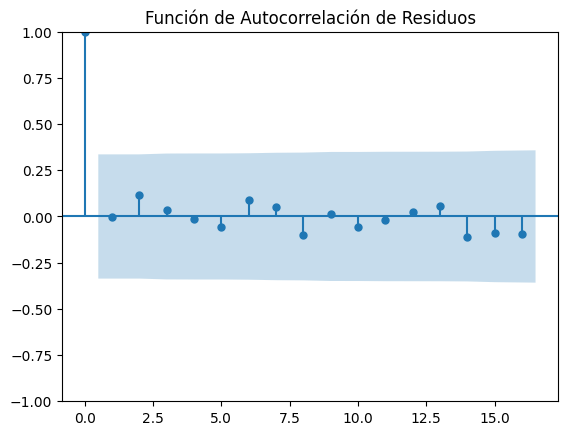

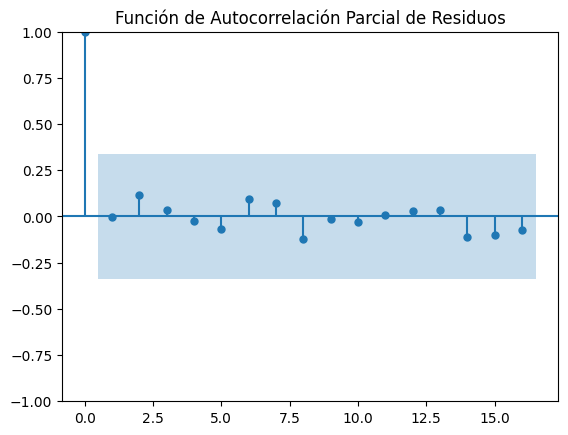

In [72]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Visualiza la función de autocorrelación de los residuos
plot_acf(model_fit.resid)
plt.title('Función de Autocorrelación de Residuos')

# Visualiza la función de autocorrelación parcial de los residuos
plot_pacf(model_fit.resid)
plt.title('Función de Autocorrelación Parcial de Residuos')


La función de autocorrelación (ACF) y la función de autocorrelación parcial (PACF) de los residuos son herramientas comunes utilizadas en el análisis de series de tiempo para evaluar la presencia de autocorrelación en los residuos de un modelo.

En la gráfica de la función de autocorrelación (ACF), se muestra cómo las observaciones en un período dado se correlacionan con las observaciones en períodos anteriores a medida que aumenta el rezago. En este caso, si los valores de la ACF varían entre 0.25 y -0.25, esto sugiere que hay una correlación débil entre los residuos en períodos anteriores. Si todos los valores fueran cercanos a cero, indicaría que los residuos son esencialmente ruido blanco y no hay autocorrelación significativa.

En la gráfica de la función de autocorrelación parcial (PACF), se muestra la correlación entre las observaciones en un período dado y las observaciones en los períodos anteriores, eliminando el efecto de los períodos intermedios. Si los valores de la PACF varían entre 0.25 y -0.25, sugiere que, incluso después de eliminar la correlación en los períodos intermedios, todavía existe una correlación débil entre los residuos en períodos anteriores. Nuevamente, si todos los valores fueran cercanos a cero, indicaría que los residuos son ruido blanco.

En general, los valores de la ACF y PACF cercanos a cero sugieren que los residuos son esencialmente ruido blanco, lo que es una buena señal. Esto indica que el modelo ARMA ha capturado la mayoría de la autocorrelación en los datos y que los residuos no muestran patrones significativos de autocorrelación. Esto es deseable en el análisis de series de tiempo, ya que los residuos deben ser ruido blanco para que el modelo sea válido.

In [74]:
from scipy.stats import shapiro

# Realiza la prueba de normalidad de Shapiro-Wilk en los residuos
stat, p = shapiro(model_fit.resid)
print('Estadística de prueba:', stat)
print('p-valor:', p)


Estadística de prueba: 0.9849265217781067
p-valor: 0.9094587564468384


La estadística de prueba (stat) se acerca a 1, lo que sugiere que los residuos tienen una distribución que se asemeja a una distribución normal. Cuanto más cercano esté el valor de la estadística a 1, mayor será la similitud con una distribución normal.

El p-valor (p) es 0.9094587564468384, lo que indica que no hay evidencia suficiente para rechazar la hipótesis nula de normalidad. En otras palabras, los residuos no se desvían significativamente de una distribución normal.

Conclusión:

En conclusión, basándonos en los resultados de la prueba de normalidad de Shapiro-Wilk, no hay evidencia que sugiera que los residuos del modelo ARMA no siguen una distribución normal. Esto es una señal positiva en el análisis de los residuos, ya que indica que los residuos se comportan de manera similar a una distribución normal, lo que es un supuesto importante para muchos métodos estadísticos.

## En resumen, aunque el modelo ARMA es una opción válida para el análisis de series temporales, los resultados sugieren que puede haber un ajuste más adecuado utilizando modelos diferentes, como se mencionó anteriormente, es esencial considerar otros enfoques, como modelos ARIMA o VAR (Vector AutoRegressive), u otros métodos de análisis de series temporales. La elección del modelo dependerá en última instancia de la naturaleza de los datos y los objetivos específicos del análisis. Es fundamental realizar una evaluación exhaustiva de diferentes modelos antes de tomar decisiones críticas basadas en los resultados del análisis de series temporales.